In [18]:
import datasets
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import evaluate
from tqdm import tqdm
import torch
from itertools import islice
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np

In [3]:
billsum_train = datasets.load_dataset("json", data_files="billsum_data/us_train_data_final_OFFICIAL.jsonl")["train"]
billsum_test = datasets.load_dataset("json", data_files="billsum_data/us_test_data_final_OFFICIAL.jsonl")["train"]

billsum_test

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['text', 'summary', 'bill_id', 'title', 'text_len', 'sum_len'],
    num_rows: 3269
})

In [4]:
model_name = "google/bigbird-pegasus-large-arxiv"

tokenizer = AutoTokenizer.from_pretrained(model_name, from_pt=True)

In [6]:
text_lengths = []
summary_lengths = []
for record in tqdm(billsum_train):
  text_lengths.append(len(tokenizer(record["text"]).input_ids))
  summary_lengths.append(len(tokenizer(record["summary"]).input_ids))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18949/18949 [01:42<00:00, 184.94it/s]


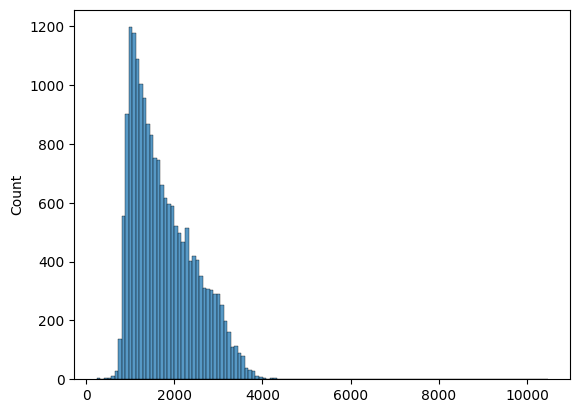

In [7]:
sns.histplot(x = text_lengths)

plt.show()

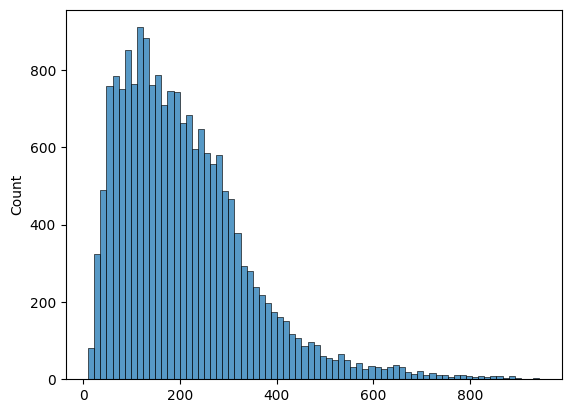

In [8]:
sns.histplot(x = summary_lengths)

plt.show()

In [9]:
bigbird_predictions = {}
with open("billsum_inference/bigbird_pegasus/billsum_test_bigbird_pred.jsonl", "r") as file:
  for line in file.readlines():
    record = json.loads(line)
    bigbird_predictions[record["title"]] = { "candidate": record["pred_summary"] }

len(bigbird_predictions.keys())

3269

In [10]:
for record in billsum_test:
  try:
    bigbird_predictions[record["title"]]["reference"] = record["summary"]
  except:
    print("Couldn't find prediction for", record["title"])

In [11]:
for i, (title, summaries) in enumerate(bigbird_predictions.items()):
  if i >= 5:
    break

  print(f"Example #{ i + 1 }")
  print("Title:", title)
  print("Reference:", summaries["reference"])
  print("Candidate:", summaries["candidate"])
  print()

Example #1
Title: To make technical corrections to the Water Resources Development Act of 1999.
Reference: Amends the Water Resources Development Act of 1999 to: (1) authorize appropriations for FY 1999 through 2009 for implementation of a long-term resource monitoring program with respect to the Upper Mississippi River Environmental Management Program (currently, such funding is designated for a program for the planning, construction, and evaluation of measures for fish and wildlife habitat rehabilitation and enhancement); (2) authorize the Secretary of the Army to carry out modifications to the navigation project for the Delaware River, Pennsylvania and Delaware, if such project as modified is technically sound, environmentally (currently, economically) acceptable, and economically justified; (3) subject certain previously deauthorized water resources development projects to the seven-year limitation governing project deauthorizations under the Act, with the exception of such a proje

In [12]:
all_candidates = []
all_references = []

for summaries in bigbird_predictions.values():
  all_candidates.append(summaries["candidate"])
  all_references.append(summaries["reference"])

In [14]:
rouge = evaluate.load('rouge')

results = rouge.compute(predictions=all_candidates, references=all_references)
print(results)

{'rouge1': 0.19312989412550227, 'rouge2': 0.025315056672049637, 'rougeL': 0.1259488307882235, 'rougeLsum': 0.14189197508297607}


In [16]:
bertscore = evaluate.load("bertscore")

results = bertscore.compute(predictions=all_candidates, references=all_references, lang="en")
#print(results)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
print(f'Average precision: {np.mean(results["precision"])}')
print(f'Average recall: {np.mean(results["recall"])}')
print(f'Average f1: {np.mean(results["f1"])}')

Average precision: 0.7907400237708034
Average recall: 0.7893033976144986
Average f1: 0.7895731773169334
